Epoch    0: Train=3.249755e-01  Val=2.870798e-01  LR=1.00e-03
Epoch   10: Train=8.304271e-02  Val=8.924737e-02  LR=1.00e-03
Epoch   20: Train=8.832655e-03  Val=7.971996e-03  LR=1.00e-03
Epoch   30: Train=4.907426e-03  Val=6.044355e-03  LR=1.00e-03
Epoch   40: Train=3.413374e-03  Val=2.266914e-03  LR=1.00e-03
Epoch   50: Train=2.792909e-03  Val=2.322181e-03  LR=1.00e-03
Epoch   60: Train=2.258374e-03  Val=2.143078e-03  LR=1.00e-03
Epoch   70: Train=1.482929e-03  Val=1.093289e-03  LR=5.00e-04
Epoch   80: Train=1.416764e-03  Val=1.369443e-03  LR=5.00e-04
Epoch   90: Train=1.186534e-03  Val=7.408444e-04  LR=2.50e-04
Epoch  100: Train=1.126607e-03  Val=8.255453e-04  LR=2.50e-04
Epoch  110: Train=1.095202e-03  Val=1.104053e-03  LR=2.50e-04
Epoch  120: Train=9.746223e-04  Val=5.537050e-04  LR=1.25e-04
Epoch  130: Train=9.085513e-04  Val=5.753834e-04  LR=1.25e-04
Epoch  140: Train=8.818876e-04  Val=5.923825e-04  LR=1.25e-04
Epoch  150: Train=8.603988e-04  Val=5.746888e-04  LR=1.25e-04
Epoch  1

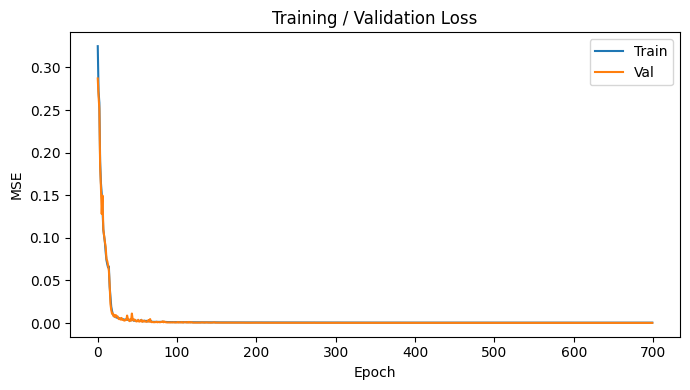

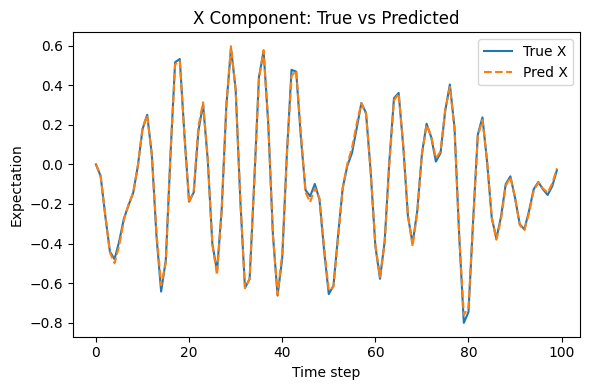

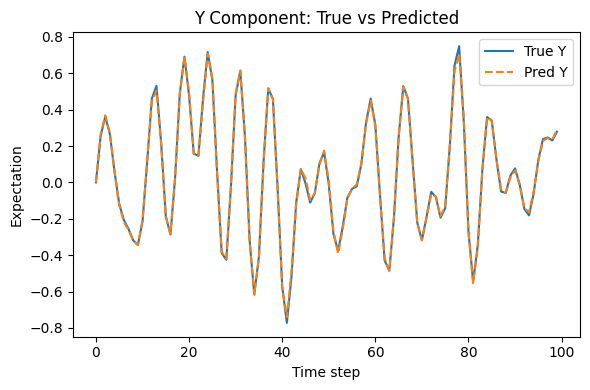

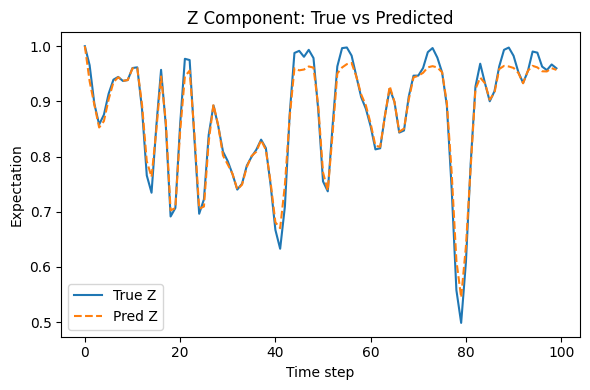

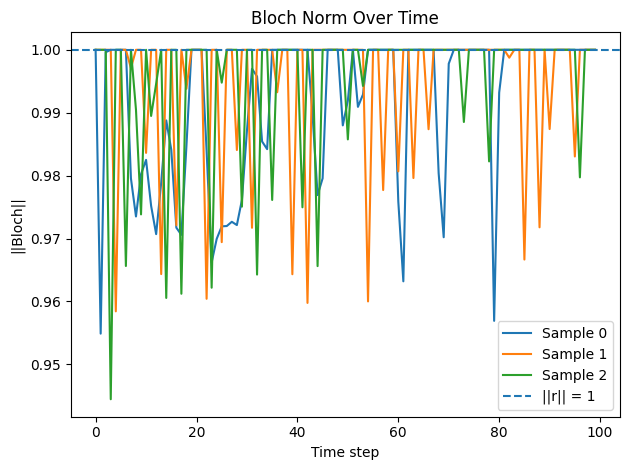


--- Running Optimal Control ---


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1343: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  current = float(metrics)


Iter    0: best ||final-target|| = 1.963855e+00, lr=5.00e-02
Iter  100: best ||final-target|| = 1.963855e+00, lr=2.50e-02
Iter  200: best ||final-target|| = 1.963855e+00, lr=6.25e-03
Iter  300: best ||final-target|| = 1.963855e+00, lr=1.56e-03
Iter  400: best ||final-target|| = 1.963855e+00, lr=3.91e-04
Iter  500: best ||final-target|| = 1.963855e+00, lr=9.77e-05
Iter  600: best ||final-target|| = 1.963855e+00, lr=2.44e-05
Iter  700: best ||final-target|| = 1.963855e+00, lr=6.10e-06
Iter  800: best ||final-target|| = 1.963855e+00, lr=1.53e-06
Iter  900: best ||final-target|| = 1.963855e+00, lr=3.81e-07


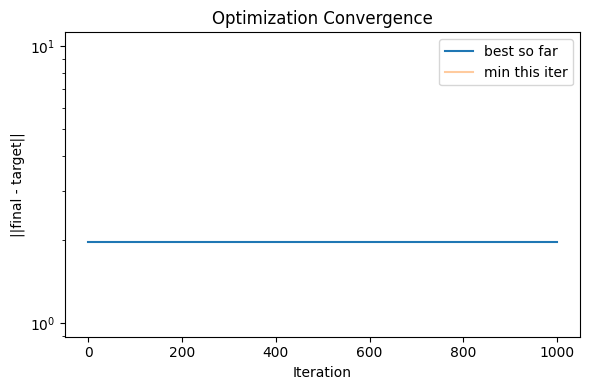

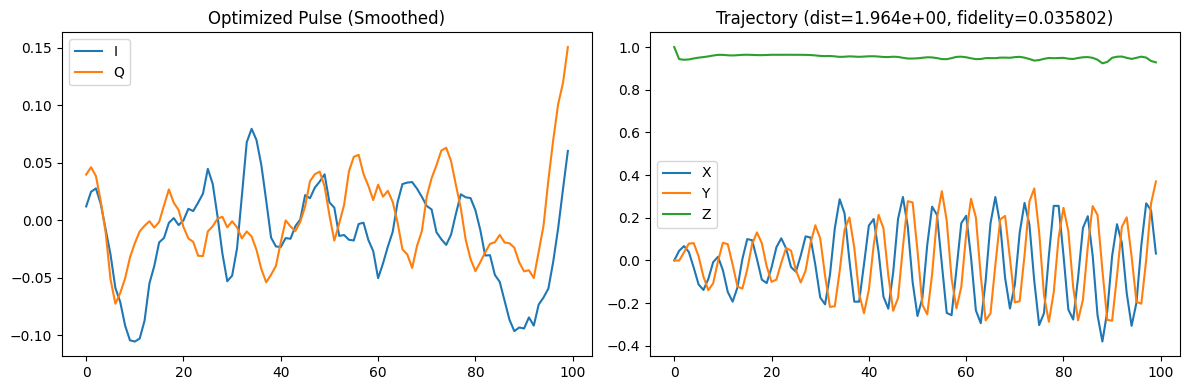

Final Bloch: [0.032252 0.370191 0.928396]
Target Bloch: [ 0.  0. -1.]
Distance error: 1.963872e+00
Fidelity:       0.035802


In [ ]:
import numpy as np
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

from qutip import basis, sigmax, sigmay, sigmaz, mesolve, expect


# =============================================================================
# 0) Repro / device
# =============================================================================
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# =============================================================================
# 1) Data generation (QuTiP)
# =============================================================================
def get_cardinal_states():
    # |0>, |1>, |+>, |->, |+i>, |-i>
    return [
        basis(2, 0),                                # Z+
        basis(2, 1),                                # Z-
        (basis(2, 0) + basis(2, 1)).unit(),         # X+
        (basis(2, 0) - basis(2, 1)).unit(),         # X-
        (basis(2, 0) + 1j*basis(2, 1)).unit(),      # Y+
        (basis(2, 0) - 1j*basis(2, 1)).unit(),      # Y-
    ]


# Bloch vectors of the six cardinal pure states (exact, by definition)
CARDINAL_BLOCH = np.array([
    [0.0,  0.0,  1.0],   # |0>
    [0.0,  0.0, -1.0],   # |1>
    [1.0,  0.0,  0.0],   # |+>
    [-1.0, 0.0,  0.0],   # |->
    [0.0,  1.0,  0.0],   # |+i>
    [0.0, -1.0,  0.0],   # |-i>
], dtype=np.float32)


def state_to_bloch(state):
    """Bloch vector r = (⟨σx⟩, ⟨σy⟩, ⟨σz⟩) as float32."""
    return np.array([
        expect(sigmax(), state),
        expect(sigmay(), state),
        expect(sigmaz(), state),
    ], dtype=np.float32)


def qubit_simulation(pulse_I, pulse_Q, initial_state, times):
    """
    Unitary evolution under:
        H(t) = 0.5 σz + 0.5 I(t) σx + 0.5 Q(t) σy

    IMPORTANT FIX:
    QuTiP's solver evaluates at non-integer times internally.
    Using np.interp avoids the "floor(int(t))" artifacts and helps training stability.
    """
    H0 = 0.5 * sigmaz()
    Hx = 0.5 * sigmax()
    Hy = 0.5 * sigmay()

    args = {
        "times": np.asarray(times, dtype=float),
        "pulse_I": np.asarray(pulse_I, dtype=float),
        "pulse_Q": np.asarray(pulse_Q, dtype=float),
    }

    def drive_I(t, args):
        return float(np.interp(t, args["times"], args["pulse_I"]))

    def drive_Q(t, args):
        return float(np.interp(t, args["times"], args["pulse_Q"]))

    H = [H0, [Hx, drive_I], [Hy, drive_Q]]

    # result = mesolve(H, initial_state, times, [], [sigmax(), sigmay(), sigmaz()], args=args)
    result = mesolve(
    H,
    initial_state,
    times,
    c_ops=[],
    e_ops=[sigmax(), sigmay(), sigmaz()],
    args=args)

    return np.stack([result.expect[0], result.expect[1], result.expect[2]], axis=-1).astype(np.float32)  # (T,3)


def create_dataset(num_samples=10000, num_steps=100, noise_std=0.04, smooth_sigma=2.0):
    """
    Returns list[dict] with keys:
      - init_state_idx (int)
      - init_bloch (3,)
      - pulse (T,2)
      - clean (T,3)   (unitary -> ideally pure, ||r||~1)
      - targets (T,3) (clean + Gaussian noise)
    """
    times = np.arange(num_steps, dtype=float)
    initial_states = get_cardinal_states()

    dataset = []
    for _ in range(num_samples):
        state_idx = np.random.randint(6)
        init_state = initial_states[state_idx]
        init_bloch = state_to_bloch(init_state)

        pulse_I = np.random.uniform(-1, 1, num_steps).astype(np.float32)
        pulse_Q = np.random.uniform(-1, 1, num_steps).astype(np.float32)

        # bandwidth limit in data
        pulse_I = gaussian_filter1d(pulse_I, sigma=smooth_sigma).astype(np.float32)
        pulse_Q = gaussian_filter1d(pulse_Q, sigma=smooth_sigma).astype(np.float32)

        pulse = np.stack([pulse_I, pulse_Q], axis=-1).astype(np.float32)  # (T,2)

        clean = qubit_simulation(pulse_I, pulse_Q, init_state, times)     # (T,3)

        noisy = clean + np.random.normal(0, noise_std, size=clean.shape).astype(np.float32)

        dataset.append({
            "init_state_idx": int(state_idx),
            "init_bloch": init_bloch.astype(np.float32),
            "pulse": pulse,
            "clean": clean,
            "targets": noisy,
        })

    return dataset


# =============================================================================
# 2) PyTorch dataset
# =============================================================================
class QubitDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, use_clean=True):
        self.dataset = dataset
        self.use_clean = use_clean

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        d = self.dataset[idx]
        y = d["clean"] if self.use_clean else d["targets"]
        return (
            torch.tensor(d["init_state_idx"], dtype=torch.long),   # ()
            torch.tensor(d["init_bloch"], dtype=torch.float32),    # (3,)
            torch.tensor(d["pulse"], dtype=torch.float32),         # (T,2)
            torch.tensor(y, dtype=torch.float32),                  # (T,3)
        )


# =============================================================================
# 3) Model: LSTM dynamics + guaranteed Bloch-ball validity (mixed + pure allowed)
# =============================================================================
def project_to_bloch_ball(r, eps=1e-8):
    """
    Guarantees ||r|| <= 1. Keeps mixed states (||r||<1) and pure states (||r||=1).
    """
    norms = torch.norm(r, dim=-1, keepdim=True)
    scale = torch.clamp(norms, min=1.0)
    return r / (scale + eps)


class QubitRNN(nn.Module):
    def __init__(self, hidden_dim=128, num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        self.encoder = nn.Linear(6, hidden_dim)
        self.rnn = nn.LSTM(2, hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.1)
        self.decoder = nn.Linear(hidden_dim, 3)

        # buffer so it moves with .to(device) and saves in state_dict
        self.register_buffer("cardinal_bloch", torch.tensor(CARDINAL_BLOCH, dtype=torch.float32))

    def forward(self, init_state_idx, pulse_seq, init_bloch_override=None):
        """
        init_state_idx: (B,)
        pulse_seq:      (B,T,2)
        init_bloch_override: (B,3) optional (useful for training to match exact init)
        returns: (B,T,3)
        """
        B = init_state_idx.shape[0]

        init_onehot = torch.nn.functional.one_hot(init_state_idx, num_classes=6).float()  # (B,6)
        h0 = torch.relu(self.encoder(init_onehot))  # (B,H)

        h0_layers = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)  # (L,B,H)
        c0_layers = torch.zeros(self.num_layers, B, h0.size(-1), device=h0.device)

        rnn_out, _ = self.rnn(pulse_seq, (h0_layers, c0_layers))   # (B,T,H)
        decoded = torch.tanh(self.decoder(rnn_out))                # (B,T,3) in [-1,1]
        decoded = project_to_bloch_ball(decoded)                   # enforce ||r||<=1

        # STRUCTURAL FIX for "t=0 Z gap":
        # Force step 0 to equal the initial Bloch vector (pre-evolution state).
        if init_bloch_override is not None:
            decoded[:, 0, :] = init_bloch_override
        else:
            decoded[:, 0, :] = self.cardinal_bloch[init_state_idx]

        return decoded


# =============================================================================
# 4) Training loss (mixed+pure allowed)
# =============================================================================
def training_loss(preds, targets):
    """
    Main supervised loss. Since we project to Bloch ball in forward(),
    we don't need huge positivity penalties anymore.
    """
    return torch.mean((preds - targets) ** 2)


def train_qubit_model(train_ds, val_ds, num_epochs=200, batch_size=128, lr=1e-3):
    model = QubitRNN(hidden_dim=128, num_layers=2).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=10
    )

    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        total = 0.0

        for init_idx, init_bloch, pulse, targets in train_loader:
            init_idx = init_idx.to(DEVICE)
            init_bloch = init_bloch.to(DEVICE)
            pulse = pulse.to(DEVICE)
            targets = targets.to(DEVICE)

            optimizer.zero_grad()
            preds = model(init_idx, pulse, init_bloch_override=init_bloch)
            loss = training_loss(preds, targets)
            loss.backward()
            optimizer.step()

            total += loss.item() * init_idx.size(0)

        avg_train = total / len(train_ds)
        train_losses.append(avg_train)

        model.eval()
        total = 0.0
        with torch.no_grad():
            for init_idx, init_bloch, pulse, targets in val_loader:
                init_idx = init_idx.to(DEVICE)
                init_bloch = init_bloch.to(DEVICE)
                pulse = pulse.to(DEVICE)
                targets = targets.to(DEVICE)

                preds = model(init_idx, pulse, init_bloch_override=init_bloch)
                loss = training_loss(preds, targets)
                total += loss.item() * init_idx.size(0)

        avg_val = total / len(val_ds)
        val_losses.append(avg_val)

        scheduler.step(avg_val)
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch:4d}: Train={avg_train:.6e}  Val={avg_val:.6e}  LR={optimizer.param_groups[0]['lr']:.2e}")

    return model, train_losses, val_losses


# =============================================================================
# 5) Diagnostics / plots
# =============================================================================
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(7, 4))
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Training / Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_trajectory(model, dataset, sample_idx=0):
    model.eval()
    init_idx, init_bloch, pulse, targets = dataset[sample_idx]

    with torch.no_grad():
        preds = model(
            init_idx.unsqueeze(0).to(DEVICE),
            pulse.unsqueeze(0).to(DEVICE),
            init_bloch_override=init_bloch.unsqueeze(0).to(DEVICE),
        )[0].cpu().numpy()

    true = targets.numpy()

    for k, name in enumerate(["X", "Y", "Z"]):
        plt.figure(figsize=(6, 4))
        plt.plot(true[:, k], label=f"True {name}")
        plt.plot(preds[:, k], "--", label=f"Pred {name}")
        plt.xlabel("Time step")
        plt.ylabel("Expectation")
        plt.title(f"{name} Component: True vs Predicted")
        plt.legend()
        plt.tight_layout()
        plt.show()


def plot_norm(model, dataset, num_samples=3):
    model.eval()
    for i in range(min(num_samples, len(dataset))):
        init_idx, init_bloch, pulse, _ = dataset[i]
        with torch.no_grad():
            preds = model(
                init_idx.unsqueeze(0).to(DEVICE),
                pulse.unsqueeze(0).to(DEVICE),
                init_bloch_override=init_bloch.unsqueeze(0).to(DEVICE),
            )
            norms = torch.norm(preds, dim=-1)[0].cpu().numpy()
        plt.plot(norms, label=f"Sample {i}")
    plt.axhline(y=1.0, linestyle="--", label="||r|| = 1")
    plt.xlabel("Time step")
    plt.ylabel("||Bloch||")
    # plt.title("Bloch Norm Over Time (<=1 enforced; mixed allowed")
    plt.title("Bloch Norm Over Time")
    plt.legend()
    plt.tight_layout()
    plt.show()


# =============================================================================
# 6) Optimal control (pulse optimization) with SAFE qubit fidelity
# =============================================================================
def smooth_pulse(pulse, kernel_size=7):
    """
    pulse: (B,T,2) -> smoothed (B,T,2)
    Gaussian-like kernel, replicate padding, grouped conv.
    """
    B, T, C = pulse.shape
    x = pulse.permute(0, 2, 1)  # (B,2,T)

    t = torch.arange(kernel_size, device=pulse.device) - (kernel_size - 1) / 2
    sigma = kernel_size / 3.0
    w = torch.exp(-0.5 * (t / sigma) ** 2)
    w = (w / w.sum()).view(1, 1, -1)        # (1,1,K)
    w = w.repeat(2, 1, 1)                   # (2,1,K)

    pad = kernel_size // 2
    xpad = torch.nn.functional.pad(x, (pad, pad), mode="replicate")
    y = torch.nn.functional.conv1d(xpad, w, groups=2)
    return y.permute(0, 2, 1)


def bloch_fidelity(r, s, eps=1e-8):
    """
    Qubit Uhlmann fidelity between states with Bloch vectors r and s (||r||<=1, ||s||<=1):
        F = 0.5 * (1 + r·s + sqrt((1-|r|^2)(1-|s|^2)))
    Works for mixed and pure states.
    Returns F in [0,1].
    """
    r2 = torch.sum(r * r, dim=-1)
    s2 = torch.sum(s * s, dim=-1)
    dot = torch.sum(r * s, dim=-1)

    term = torch.sqrt(torch.clamp((1.0 - r2) * (1.0 - s2), min=0.0))
    F = 0.5 * (1.0 + dot + term)
    return torch.clamp(F, 0.0, 1.0)

def optimize_pulse(
    model,
    init_state_idx,
    target_bloch,
    num_steps,
    batch_size=20,
    max_amp=1.0,
    lr=0.05,
    iterations=1000,
    smooth_kernel=7):

    # --- IMPORTANT FIX FOR cuDNN LSTM BACKWARD ---
    was_training = model.training
    old_dropout = model.rnn.dropout if hasattr(model, "rnn") else None

    model.train()                 # cuDNN RNN backward requires train mode
    if old_dropout is not None:
        model.rnn.dropout = 0.0   # keep control deterministic

    # freeze weights (still fine in train mode)
    for p in model.parameters():
        p.requires_grad = False

    # (optional but often helpful for cuDNN)
    if hasattr(model, "rnn"):
        model.rnn.flatten_parameters()


    target = torch.tensor(target_bloch, dtype=torch.float32, device=DEVICE).view(1, 3).repeat(batch_size, 1)
    init_idx_batch = torch.tensor([init_state_idx], dtype=torch.long, device=DEVICE).repeat(batch_size)

    opt_pulse = torch.normal(0.0, 0.1, size=(batch_size, num_steps, 2), device=DEVICE, requires_grad=True)
    optimizer = torch.optim.Adam([opt_pulse], lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=50)

    best_dist = float("inf")
    best_pulse = None
    min_dist_hist = []
    best_dist_hist = []
    best_so_far = float("inf")


    for it in range(iterations):
        optimizer.zero_grad()

        scaled = torch.tanh(opt_pulse) * max_amp
        smoothed = smooth_pulse(scaled, kernel_size=smooth_kernel)

        preds = model(init_idx_batch, smoothed)
        final = preds[:, -1, :]

        F = bloch_fidelity(final, target)
        F = torch.clamp(F, 1e-7, 1.0)
        loss_fid = -torch.log(F)

        dist = torch.norm(final - target, dim=-1)
        loss_dist = dist

        diffs = scaled[:, 1:] - scaled[:, :-1]
        loss_smooth = torch.mean(diffs * diffs, dim=(1, 2))

        total = (1.0 * loss_fid + 1.0 * loss_dist + 0.01 * loss_smooth).mean()
        total.backward()
        optimizer.step()
        scheduler.step(total)

        with torch.no_grad():
          dmin, argmin = torch.min(dist, dim=0)

          # log every iteration
          dmin_val = float(dmin.item())
          min_dist_hist.append(dmin_val)
          best_so_far = min(best_so_far, dmin_val)
          best_dist_hist.append(best_so_far)

          # keep best pulse
          if dmin_val < best_dist:
              best_dist = dmin_val
              best_pulse = smoothed[argmin].detach().cpu().numpy()

        if it % 100 == 0:
            print(f"Iter {it:4d}: best ||final-target|| = {best_dist:.6e}, lr={optimizer.param_groups[0]['lr']:.2e}")

        if it % 50 == 0:
          with torch.no_grad():
            print("max |I|,|Q|:", smoothed.abs().max().item())

        if best_dist < 1e-4:
            print(f"Converged at iter {it}!")
            break

    # --- restore original mode/dropout ---
    if old_dropout is not None:
        model.rnn.dropout = old_dropout
    if not was_training:
        model.eval()

    history = {"min_dist": min_dist_hist, "best_dist": best_dist_hist}
    return best_pulse, history



def analyze_control_result(model, init_state_idx, pulse, target_bloch):
    model.eval()
    pulse_t = torch.tensor(pulse, dtype=torch.float32, device=DEVICE).unsqueeze(0)

    with torch.no_grad():
        traj = model(torch.tensor([init_state_idx], dtype=torch.long, device=DEVICE), pulse_t)[0].cpu().numpy()

    final = traj[-1]
    dist = np.linalg.norm(final - target_bloch)

    # Fidelity (mixed+pure formula)
    r2 = np.dot(final, final)
    s2 = np.dot(target_bloch, target_bloch)
    dot = np.dot(final, target_bloch)
    F = 0.5 * (1.0 + dot + np.sqrt(max(0.0, (1.0 - r2) * (1.0 - s2))))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(pulse[:, 0], label="I")
    ax1.plot(pulse[:, 1], label="Q")
    ax1.set_title("Optimized Pulse (Smoothed)")
    ax1.legend()

    ax2.plot(traj[:, 0], label="X")
    ax2.plot(traj[:, 1], label="Y")
    ax2.plot(traj[:, 2], label="Z")
    ax2.set_title(f"Trajectory (dist={dist:.3e}, fidelity={F:.6f})")
    ax2.legend()

    plt.tight_layout()
    plt.show()

    print("Final Bloch:", np.round(final, 6))
    print("Target Bloch:", np.round(target_bloch, 6))
    print(f"Distance error: {dist:.6e}")
    print(f"Fidelity:       {F:.6f}")


# =============================================================================
# 7) Main
# =============================================================================
if __name__ == "__main__":
    # --- Generate data
    all_data = create_dataset(num_samples=10000, num_steps=100, noise_std=0.04, smooth_sigma=2.0)

    # Split train/val/test
    train_data = all_data[:8200]
    val_data   = all_data[8200:9400]
    test_data  = all_data[9400:]


    train_ds = QubitDataset(train_data, use_clean=True)
    val_ds   = QubitDataset(val_data, use_clean=True)
    test_ds  = QubitDataset(test_data, use_clean=True)


    zs_min = np.array([d["clean"][:,2].min() for d in train_data])
    print("Frac with min Z < 0:", (zs_min < 0).mean())

    zs_final = np.array([d["clean"][-1,2] for d in train_data])
    print("Frac with final Z < 0:", (zs_final < 0).mean())
    # ---------------------------

    # --- Train model
    model, train_losses, val_losses = train_qubit_model(
        train_ds, val_ds,
        num_epochs=700,
        batch_size=128,
        lr=1e-3
    )

    # --- Plots
    plot_loss_curves(train_losses, val_losses)
    plot_trajectory(model, test_ds, sample_idx=10)
    plot_norm(model, test_ds, num_samples=3)


    start_idx = 0
    target_vec = np.array([0.0, 0.0, -1.0], dtype=np.float32)

    print("\n--- Running Optimal Control ---")
    best_pulse, hist = optimize_pulse(
        model,
        init_state_idx=start_idx,
        target_bloch=target_vec,
        num_steps=100,
        batch_size=20,
        max_amp=1.0,
        lr=0.05,
        iterations=1000,
        smooth_kernel=7,
    )

    # Plot convergence
    plt.figure(figsize=(6, 4))
    plt.plot(hist["best_dist"], label="best so far")
    plt.plot(hist["min_dist"], alpha=0.4, label="min this iter")
    plt.yscale("log")
    plt.title("Optimization Convergence")
    plt.xlabel("Iteration")
    plt.ylabel("||final - target||")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Then analyze/plot the final trajectory/pulse
    analyze_control_result(model, start_idx, best_pulse, target_vec)

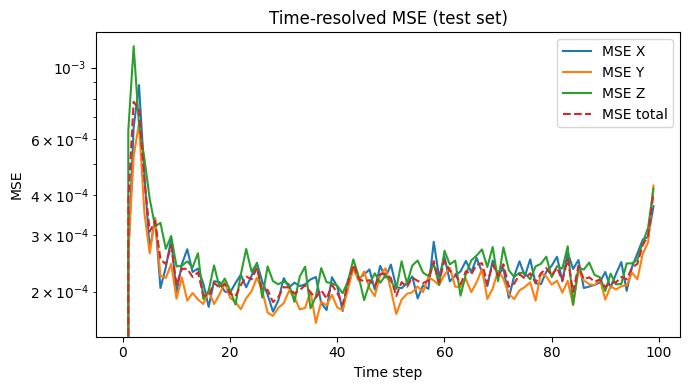

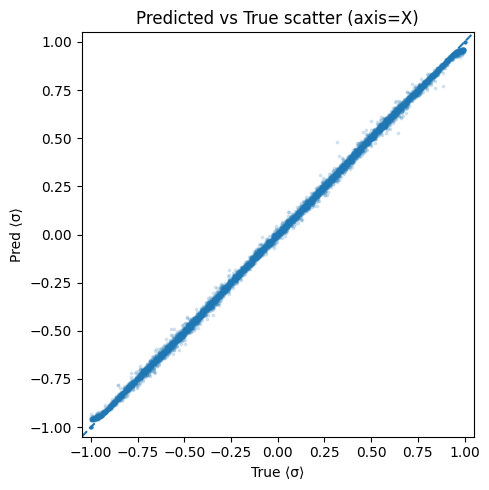

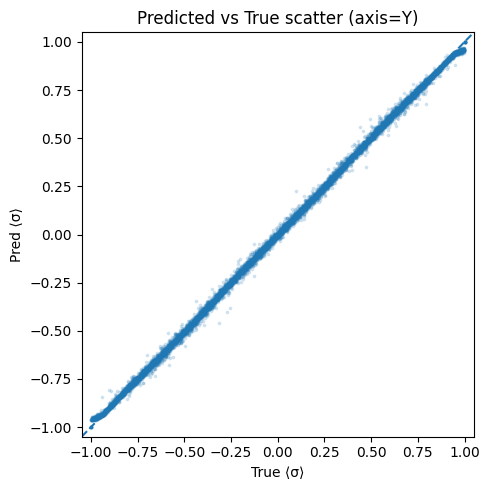

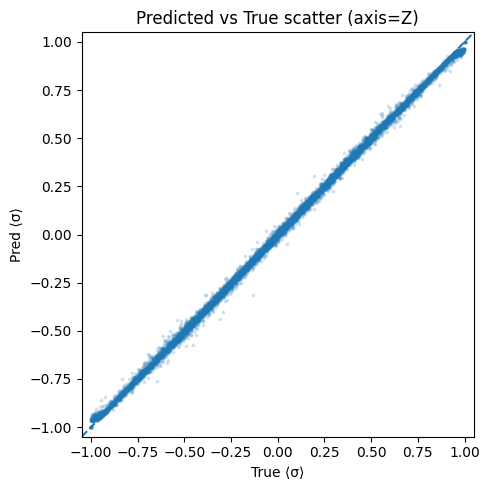

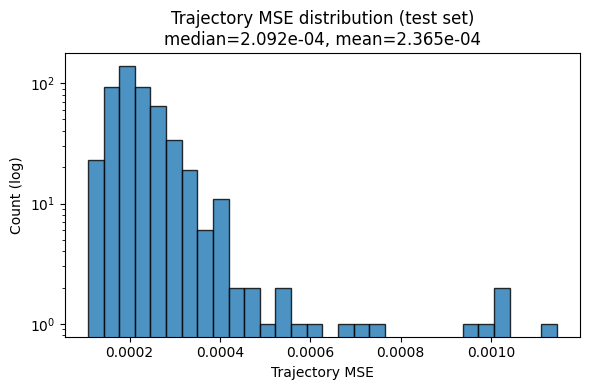

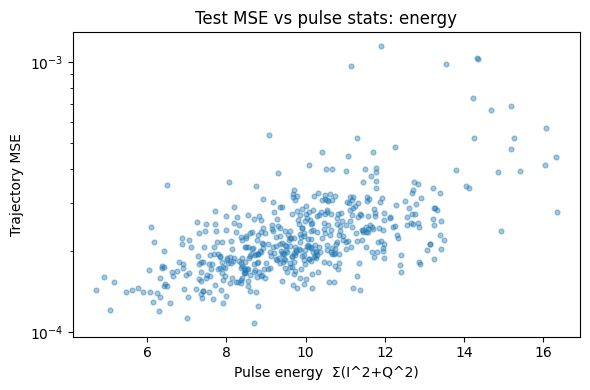

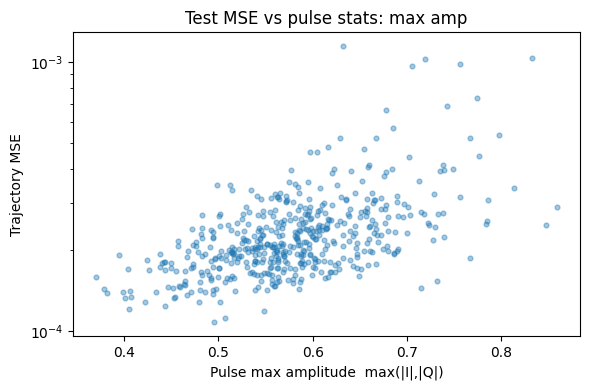

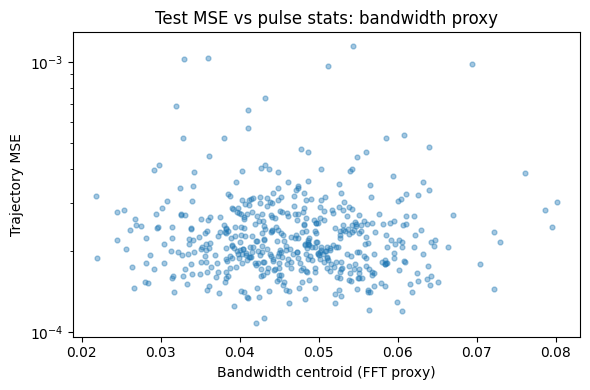

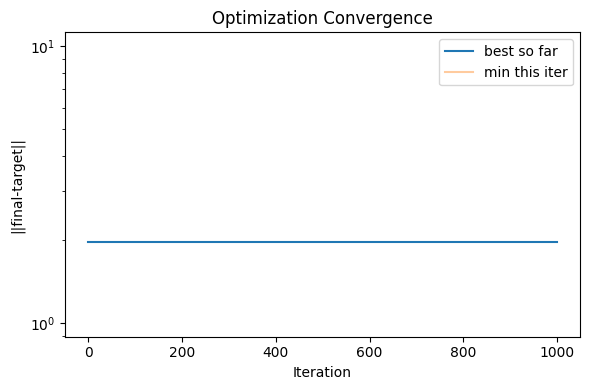

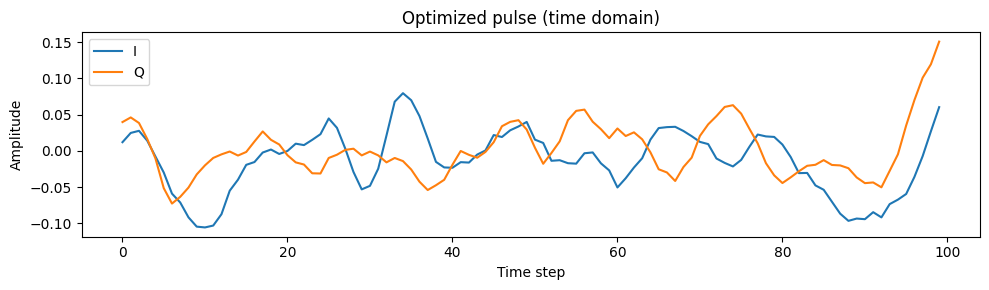

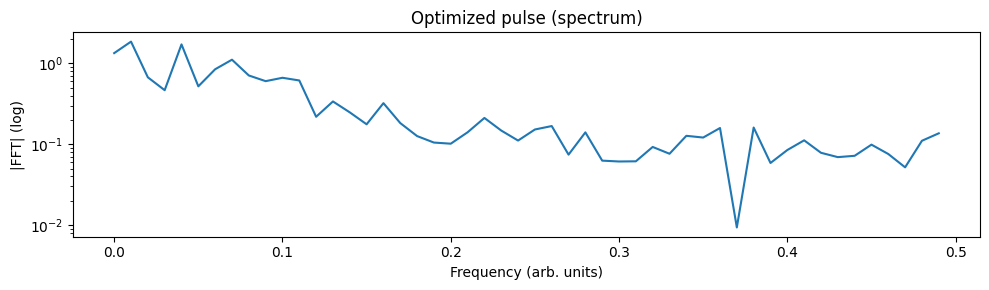

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# -----------------------------
# Helpers
# -----------------------------
def _get_device(model):
    return next(model.parameters()).device

def _to(x, device):
    return x.to(device) if hasattr(x, "to") else x

def _as_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def _fft_spectrum_1d(signal, dt=1.0):
    """Returns positive freqs and magnitude spectrum."""
    signal = np.asarray(signal)
    fft_vals = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), d=dt)
    mag = np.abs(fft_vals)
    pos = freqs >= 0
    return freqs[pos], mag[pos]

def _bandwidth_centroid(pulse_IQ, dt=1.0, eps=1e-12):
    """
    A simple bandwidth proxy: spectral centroid of complex envelope u(t)=I+iQ.
    """
    u = pulse_IQ[:, 0] + 1j * pulse_IQ[:, 1]
    freqs, mag = _fft_spectrum_1d(u, dt=dt)
    power = mag**2
    denom = power.sum() + eps
    return float((freqs * power).sum() / denom)

def _pulse_energy(pulse_IQ):
    return float(np.sum(pulse_IQ**2))

def _pulse_maxamp(pulse_IQ):
    return float(np.max(np.abs(pulse_IQ)))

# -----------------------------
# 1) Time-resolved MSE vs time step (X/Y/Z + total)
# -----------------------------
@torch.no_grad()
def plot_time_resolved_mse(model, dataset, n_samples=1024, batch_size=256, title="Time-resolved MSE"):
    model.eval()
    device = _get_device(model)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    count = 0

    sum_sq = None  # (T,3)
    T = None

    for init_idx, init_bloch, pulse, targets in loader:
        init_idx = _to(init_idx, device)
        init_bloch = _to(init_bloch, device)
        pulse = _to(pulse, device)
        targets = _to(targets, device)

        preds = model(init_idx, pulse, init_bloch_override=init_bloch) if "init_bloch_override" in model.forward.__code__.co_varnames else model(init_idx, pulse)
        err = preds - targets  # (B,T,3)

        if sum_sq is None:
            T = err.shape[1]
            sum_sq = torch.zeros((T, 3), device=device)

        sum_sq += torch.sum(err**2, dim=0)  # sum over batch -> (T,3)
        count += err.shape[0]
        if count >= n_samples:
            break

    mse_t = (sum_sq / max(count, 1)).cpu().numpy()  # (T,3)
    mse_total = mse_t.mean(axis=1)                  # (T,)

    plt.figure(figsize=(7,4))
    plt.plot(mse_t[:,0], label="MSE X")
    plt.plot(mse_t[:,1], label="MSE Y")
    plt.plot(mse_t[:,2], label="MSE Z")
    plt.plot(mse_total,  label="MSE total", linestyle="--")
    plt.yscale("log")
    plt.xlabel("Time step")
    plt.ylabel("MSE")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------
# 2) Predicted vs True scatter (calibration) for a chosen axis
# -----------------------------
@torch.no_grad()
def plot_pred_vs_true_scatter(model, dataset, axis=2, n_points=10000, batch_size=256, title=None):
    """
    axis: 0=X, 1=Y, 2=Z
    """
    model.eval()
    device = _get_device(model)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    xs = []
    ys = []

    needed = n_points
    for init_idx, init_bloch, pulse, targets in loader:
        init_idx = _to(init_idx, device)
        init_bloch = _to(init_bloch, device)
        pulse = _to(pulse, device)
        targets = _to(targets, device)

        preds = model(init_idx, pulse, init_bloch_override=init_bloch) if "init_bloch_override" in model.forward.__code__.co_varnames else model(init_idx, pulse)

        # flatten across time and batch
        p = preds[..., axis].reshape(-1).cpu().numpy()
        t = targets[..., axis].reshape(-1).cpu().numpy()

        # take a chunk
        take = min(needed, len(p))
        xs.append(t[:take])
        ys.append(p[:take])
        needed -= take
        if needed <= 0:
            break

    x = np.concatenate(xs)
    y = np.concatenate(ys)

    if title is None:
        title = f"Predicted vs True scatter (axis={['X','Y','Z'][axis]})"

    plt.figure(figsize=(5,5))
    plt.scatter(x, y, s=3, alpha=0.15)
    lim = 1.05
    plt.plot([-lim, lim], [-lim, lim], linestyle="--")
    plt.xlim([-lim, lim]); plt.ylim([-lim, lim])
    plt.xlabel("True ⟨σ⟩")
    plt.ylabel("Pred ⟨σ⟩")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 3) Per-trajectory MSE distribution + summary
# -----------------------------
@torch.no_grad()
def plot_trajectory_mse_hist(model, dataset, n_traj=500, batch_size=64, title="Trajectory MSE distribution"):
    model.eval()
    device = _get_device(model)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    mses = []
    for init_idx, init_bloch, pulse, targets in loader:
        init_idx = _to(init_idx, device)
        init_bloch = _to(init_bloch, device)
        pulse = _to(pulse, device)
        targets = _to(targets, device)

        preds = model(init_idx, pulse, init_bloch_override=init_bloch) if "init_bloch_override" in model.forward.__code__.co_varnames else model(init_idx, pulse)
        mse_batch = torch.mean((preds - targets)**2, dim=(1,2)).cpu().numpy()  # (B,)
        mses.append(mse_batch)

        if sum(len(a) for a in mses) >= n_traj:
            break

    mses = np.concatenate(mses)[:n_traj]

    plt.figure(figsize=(6,4))
    plt.hist(mses, bins=30, edgecolor="black", alpha=0.8)
    plt.yscale("log")
    plt.xlabel("Trajectory MSE")
    plt.ylabel("Count (log)")
    plt.title(title + f"\nmedian={np.median(mses):.3e}, mean={np.mean(mses):.3e}")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 4) MSE vs pulse stats (energy / max amplitude / bandwidth centroid)
#    NOTE: This needs access to pulses; you can pass either:
#      - data_list: your original list of dicts (test_data), OR
#      - dataset: a QubitDataset (we'll pull pulse from it)
# -----------------------------
@torch.no_grad()
def plot_mse_vs_pulse_stats(model, dataset, n_traj=500, dt=1.0, batch_size=64, title_prefix="MSE vs pulse stats"):
    model.eval()
    device = _get_device(model)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    mses = []
    energies = []
    maxamps = []
    cents = []

    collected = 0
    for init_idx, init_bloch, pulse, targets in loader:
        init_idx = _to(init_idx, device)
        init_bloch = _to(init_bloch, device)
        pulse_dev = _to(pulse, device)
        targets = _to(targets, device)

        preds = model(init_idx, pulse_dev, init_bloch_override=init_bloch) if "init_bloch_override" in model.forward.__code__.co_varnames else model(init_idx, pulse_dev)
        mse_batch = torch.mean((preds - targets)**2, dim=(1,2)).cpu().numpy()

        pulse_np = pulse.cpu().numpy()  # (B,T,2)
        for b in range(pulse_np.shape[0]):
            p = pulse_np[b]
            energies.append(_pulse_energy(p))
            maxamps.append(_pulse_maxamp(p))
            cents.append(_bandwidth_centroid(p, dt=dt))

        mses.extend(list(mse_batch))
        collected += pulse_np.shape[0]
        if collected >= n_traj:
            break

    mses = np.array(mses[:n_traj])
    energies = np.array(energies[:n_traj])
    maxamps = np.array(maxamps[:n_traj])
    cents = np.array(cents[:n_traj])

    # scatter helper
    def _scatter(x, y, xlabel, ylabel="Trajectory MSE", title=""):
        plt.figure(figsize=(6,4))
        plt.scatter(x, y, s=12, alpha=0.4)
        plt.yscale("log")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.tight_layout()
        plt.show()

    _scatter(energies, mses, xlabel="Pulse energy  Σ(I^2+Q^2)", title=f"{title_prefix}: energy")
    _scatter(maxamps, mses, xlabel="Pulse max amplitude  max(|I|,|Q|)", title=f"{title_prefix}: max amp")
    _scatter(cents, mses, xlabel="Bandwidth centroid (FFT proxy)", title=f"{title_prefix}: bandwidth proxy")

# -----------------------------
# 5) Pulse waveform + spectrum (FFT)
# -----------------------------
def plot_pulse_and_spectrum(pulse_IQ, dt=1.0, title="Pulse + Spectrum"):
    pulse_IQ = np.asarray(pulse_IQ)
    I = pulse_IQ[:,0]
    Q = pulse_IQ[:,1]
    u = I + 1j*Q

    freqs, mag = _fft_spectrum_1d(u, dt=dt)

    plt.figure(figsize=(10,3))
    plt.plot(I, label="I")
    plt.plot(Q, label="Q")
    plt.xlabel("Time step")
    plt.ylabel("Amplitude")
    plt.title(title + " (time domain)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,3))
    plt.plot(freqs, mag)
    plt.yscale("log")
    plt.xlabel("Frequency (arb. units)")
    plt.ylabel("|FFT| (log)")
    plt.title(title + " (spectrum)")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 6) Optimization convergence plot (works for dict history OR list)
# -----------------------------
def plot_optimization_convergence(hist, title="Optimization Convergence"):
    plt.figure(figsize=(6,4))
    if isinstance(hist, dict):
        if "best_dist" in hist and len(hist["best_dist"]) > 0:
            plt.plot(hist["best_dist"], label="best so far")
        if "min_dist" in hist and len(hist["min_dist"]) > 0:
            plt.plot(hist["min_dist"], alpha=0.4, label="min this iter")
        plt.legend()
        plt.xlabel("Iteration")
        plt.ylabel("||final-target||")
        plt.yscale("log")
        plt.title(title)
        plt.tight_layout()
        plt.show()
    else:
        # assume list/np array
        plt.plot(hist, label="dist history")
        plt.legend()
        plt.xlabel("Iteration")
        plt.ylabel("||final-target||")
        plt.yscale("log")
        plt.title(title)
        plt.tight_layout()
        plt.show()

# -----------------------------
# One-call convenience wrapper
# -----------------------------
def run_replication_plots(model, test_ds, *,
                          dt=1.0,
                          n_eval_time=1024,
                          n_scatter_points=10000,
                          n_traj_hist=500,
                          n_traj_stats=500,
                          hist=None,
                          best_pulse=None):
    plot_time_resolved_mse(model, test_ds, n_samples=n_eval_time, title="Time-resolved MSE (test set)")
    plot_pred_vs_true_scatter(model, test_ds, axis=0, n_points=n_scatter_points)
    plot_pred_vs_true_scatter(model, test_ds, axis=1, n_points=n_scatter_points)
    plot_pred_vs_true_scatter(model, test_ds, axis=2, n_points=n_scatter_points)
    plot_trajectory_mse_hist(model, test_ds, n_traj=n_traj_hist, title="Trajectory MSE distribution (test set)")
    plot_mse_vs_pulse_stats(model, test_ds, n_traj=n_traj_stats, dt=dt, title_prefix="Test MSE vs pulse stats")

    if hist is not None:
        plot_optimization_convergence(hist)

    if best_pulse is not None:
        plot_pulse_and_spectrum(best_pulse, dt=dt, title="Optimized pulse")

# -----------------------------
# Example usage (NO retraining)
# -----------------------------
# After training, just run:
run_replication_plots(model, test_ds, dt=1.0, hist=hist, best_pulse=best_pulse)
